# Fitting stellar parameters

The central purpose of **isochrones** is to infer the physical properties of stars given arbitrary observations. This is accomplished via the `StarModel` object.  For simplest usage, a `StarModel` is initialized with a `ModelGridInterpolator` and observed properties, provided as `(value, uncertainty)` pairs.  Also, while the vanilla `StarModel` object (which is mostly the same as the **isochrones** v1 `StarModel` object) can still be used to fit a single star, **isochrones** v2 has a new `SingleStarModel` available, that has a more optimized likelihood implementation, for significantly faster inference.

## Defining a star model

First, let's generate some "observed" properties according to the model grids themselves.  Remember that `.generate()` only works with the evolution track interpolator.

In [1]:
from isochrones.mist import MIST_EvolutionTrack, MIST_Isochrone

track = MIST_EvolutionTrack()

mass, age, feh, distance, AV = 1.0, 9.74, -0.05, 100, 0.02

# Using return_dict here rather than return_df, because we just want scalar values
true_props = track.generate(mass, age, feh, distance=distance, AV=AV, return_dict=True)
true_props

{'nu_max': 2617.5691700617886,
 'logg': 4.370219109480715,
 'eep': 380.0,
 'initial_mass': 1.0,
 'radius': 1.0813017873811603,
 'logTeff': 3.773295968705084,
 'mass': 0.9997797219140423,
 'density': 1.115827651504971,
 'Mbol': 4.4508474939623826,
 'phase': 0.0,
 'feh': -0.09685557997282962,
 'Teff': 5934.703385987951,
 'logL': 0.11566100241504726,
 'delta_nu': 126.60871562200438,
 'interpolated': 0.0,
 'star_age': 5522019067.711771,
 'age': 9.74119762492735,
 'dt_deep': 0.0036991465241712263,
 'J': 8.435233804866742,
 'H': 8.124109062114325,
 'K': 8.09085566863133,
 'G': 9.387465543790636,
 'BP': 9.680097761608252,
 'RP': 8.928888526297722,
 'W1': 8.079124865544092,
 'W2': 8.090757185192754,
 'W3': 8.06683507215844,
 'TESS': 8.923262483762786,
 'Kepler': 9.301490687837552}

Now, we can define a starmodel with these "observations", this time using the isochrone grid interpolator.  We use the optimized `SingleStarModel` object.

In [2]:
from isochrones import SingleStarModel, get_ichrone

mist = get_ichrone('mist')

uncs = dict(Teff=80, logg=0.1, feh=0.1, phot=0.02)
props = {p: (true_props[p], uncs[p]) for p in ['Teff', 'logg', 'feh']}
props.update({b: (true_props[b], uncs['phot']) for b in 'JHK'})

# Let's also give an appropriate parallax, in mas
props.update({'parallax': (1000./distance, 0.1)})

mod = SingleStarModel(mist, name='demo', **props)

And we can see the prior, likelihood, and posterior at the true parameters:

In [3]:
eep = mist.get_eep(mass, age, feh, accurate=True)
pars = [eep, age, feh, distance, AV]

mod.lnprior(pars), mod.lnlike(pars), mod.lnpost(pars)

(-23.05503287088296, -20.716150242083508, -43.77118311296647)

If we stray from these parameters, we can see the likelihood decrease:

In [4]:
pars2 = [eep + 3, age - 0.05, feh + 0.02, distance, AV]
mod.lnprior(pars2), mod.lnlike(pars2), mod.lnpost(pars2)

(-23.251706955307853, -85.08590699022739, -108.33761394553524)

How long does a posterior evaluation take?

In [5]:
%timeit mod.lnpost(pars)

1000 loops, best of 3: 369 µs per loop


In [6]:
from isochrones import BinaryStarModel

mod2 = BinaryStarModel(mist, **props)

In [7]:
pars2 = [eep, eep - 20, age, feh, distance, AV]
%timeit mod2.lnpost(pars2)

The slowest run took 373.39 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 429 µs per loop


In [8]:
from isochrones import TripleStarModel
mod3 = TripleStarModel(mist, **props)
pars3 = [eep, eep-20, eep-40, age, feh, distance, AV]
%timeit mod3.lnpost(pars3)

1000 loops, best of 3: 541 µs per loop


## Priors

As you may have noticed, we have not explictly defined any priors on our parameters.  They were defined for you, but you may wish to know what they are, and/or to change them.  

In [9]:
mod._priors

{'mass': <isochrones.priors.ChabrierPrior at 0x1c47e270f0>,
 'feh': <isochrones.priors.FehPrior at 0x1c47e27358>,
 'age': <isochrones.priors.AgePrior at 0x1c47e27748>,
 'distance': <isochrones.priors.DistancePrior at 0x1c47e27390>,
 'AV': <isochrones.priors.AVPrior at 0x1c47e27400>,
 'eep': <isochrones.priors.EEP_prior at 0x1c47e274e0>}

You can sample from these priors:

In [10]:
samples = mod.sample_from_prior(1000)
samples

age       feh     distance        AV   eep
0     9.775384  0.004928  9585.312354  0.058294   415
1     9.690678  0.318313  5460.742158  0.212007   295
2     9.317426 -0.008935  5381.226921  0.144259   265
3     9.721345 -0.131058  7867.502875  0.228851   295
4     9.374286 -0.325079  9590.728624  0.954659   350
5     9.293293  0.229220  9574.055273  0.713866   293
6     9.941975  0.178338  7788.336554  0.100102   272
7     9.436477  0.231631  9148.585364  0.204715   314
8     9.743647 -0.396267  6767.456426  0.383272   460
9     9.607588 -0.236938  4317.243131  0.795216   327
10   10.057273 -0.236801  9031.515061  0.488995   314
11    9.645887 -0.338786  9055.303060  0.408045  1702
12    9.997611 -0.214726  8452.833760  0.398581   327
13    9.926111 -0.063765  9726.761618  0.544188   321
14    9.845896 -0.106017  9148.167681  0.455272   292
15    9.761015 -0.051480  8247.211954  0.379722   253
16    9.286601 -0.186755  7113.433648  0.504276   451
17    8.124025 -0.138695  9335.360257  0.445926   380
18    9.357514  0.067101  7737.470105  0.752912   300
19    9.595645  0.107345  7115.589991  0.231624   420
20    9.933118 -0.048234  8424.490753  0.139511  1692
21   10.105196  0.292670  9485.836532  0.366055   331
22   10.040531  0.014999  9296.367644  0.185203   314
23    9.967137  0.000672  8552.101985  0.791577   254
24   10.128790 -0.176654  6727.495813  0.494750   345
25    9.854273 -0.183929  5380.753272  0.945978   407
26    9.808855  0.074433  8664.219066  0.692098   455
27    9.917164  0.202846  7496.956324  0.363808   389
28    9.630302 -0.373880  8555.632299  0.287120   322
29    9.179908 -0.199734  9856.026771  0.303459   300
..         ...       ...          ...       ...   ...
970  10.086391  0.106938  7592.165249  0.180709   314
971  10.085083 -0.036016  7027.634747  0.314156   299
972   9.287464  0.265288  6042.848103  0.144724   402
973   9.955503 -0.080510  6262.492050  0.611200   327
974   9.616142 -0.342509  5069.839242  0.567513   349
975  10.075706 -0.130103  5829.432844  0.892020   299
976  10.028535  0.193184  4257.798238  0.293645   329
977   9.574676  0.085395  9752.502653  0.703944   357
978   9.556853 -0.140753  8530.526505  0.871235   334
979   9.821810 -0.118098  8972.965633  0.026728   397
980  10.105103  0.104010  9992.769437  0.343932   292
981   9.853596 -0.118408  6035.299187  0.686813   254
982   9.312975 -0.038113  8689.991781  0.047170   324
983   8.971418  0.238024  5797.572151  0.773175   268
984   9.664546 -0.028603  9719.254429  0.707218   347
985   9.924745 -0.216946  9422.814918  0.292175   292
986   9.624291 -0.034933  4359.825182  0.661057   317
987   9.947794 -0.264508  8355.572420  0.301372   292
988   9.766796  0.070148  9155.900363  0.597846   292
989   9.960194  0.026427  7655.336536  0.002166   265
990   9.488527 -0.094431  9896.426901  0.662185   271
991  10.105075  0.145627  3359.853867  0.416843   489
992   9.994699 -0.246844  6033.657596  0.198885   271
993   9.369871  0.052412  2669.191340  0.294969   317
994   9.903893  0.176871  8832.480953  0.128152   295
995   9.864971  0.142656  9366.389176  0.782361   347
996   9.968736  0.027372  8748.808096  0.300267   351
997   9.525780  0.005426  6651.084393  0.508013   247
998   9.290521 -0.064370  8489.972371  0.615413   296
999  10.131466  0.077783  8694.197822  0.833533   271

[1000 rows x 5 columns]

Remember, these are the fit parameters:

In [11]:
mod.param_names

('eep', 'age', 'feh', 'distance', 'AV')

Let's turn this into a dataframe, and visualize it.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
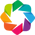

:Layout
   .Histogram.I   :Histogram   [eep]   (eep_frequency)
   .Histogram.II  :Histogram   [age]   (age_frequency)
   .Histogram.III :Histogram   [feh]   (feh_frequency)
   .Histogram.IV  :Histogram   [distance]   (distance_frequency)
   .Histogram.V   :Histogram   [AV]   (AV_frequency)
   .Histogram.VI  :Histogram   [mass]   (mass_frequency)

In [12]:
import pandas as pd
import holoviews as hv
import hvplot.pandas
hv.extension('bokeh')

def plot_samples(samples):
    df = pd.DataFrame(samples, columns=['eep', 'age', 'feh', 'distance', 'AV'])
    df['mass'] = mod.ic.interp_value([df.eep, df.age, df.feh], ['mass'])
    return hv.Layout([df.hvplot.hist(c).options(width=300) for c in df.columns]).cols(3)

plot_samples(samples)

Note that there are some built-in defaults here to be aware of.  The metallicity distribution is based on a local metallicity prior from SDSS, the distance prior has a maximum distance of 10kpc, and AV is flat from 0 to 1.  Now, let's change our distance prior to only go out to 1000pc, and our metallicity distribution to be flat between -2 and 0.5.

In [13]:
from isochrones.priors import FlatPrior, DistancePrior
mod.set_prior(feh=FlatPrior((-2, 0.5)), distance=DistancePrior(1000))

In [14]:
plot_samples(mod.sample_from_prior(1000))

:Layout
   .Histogram.I   :Histogram   [eep]   (eep_frequency)
   .Histogram.II  :Histogram   [age]   (age_frequency)
   .Histogram.III :Histogram   [feh]   (feh_frequency)
   .Histogram.IV  :Histogram   [distance]   (distance_frequency)
   .Histogram.V   :Histogram   [AV]   (AV_frequency)
   .Histogram.VI  :Histogram   [mass]   (mass_frequency)

Also note that the default mass prior is the Chabrier broken powerlaw, which is nifty:

In [15]:
pd.Series(mod._priors['mass'].sample(10000), name='mass').hvplot.hist(bins=100, bin_range=(0, 5))

:Histogram   [mass]   (mass_frequency)

You can also define a metallicity prior to have a different mix of halo and (local) disk:

In [16]:
from isochrones.priors import FehPrior

pd.Series(FehPrior(halo_fraction=0.5).sample(10000), name='feh').hvplot.hist()

:Histogram   [feh]   (feh_frequency)

## Sampling the posterior

Once you have defined your stellar model and are happy with your priors, you may either execute your optimization/sampling method of choice using the `.lnpost()` method as your posterior, or you may use the built-in **MultiNest** fitting routine with `.fit()`.  One thing to note especially is that the **MultiNest** chains get automatically created in a `chains` subdirectory from wherever you execute `.fit()`, with a basename for the files that you can access with:

In [17]:
mod.mnest_basename

'./chains/demo-mist-single-'

This can be changed or overwritten in two ways, which is often a good idea to avoid clashes between different fits with the same default basename.  You can either by pass an explicit `basename` keyword to `.fit()`, or you can set a name attribute, as we did when initializing this model.  OK, now we will run the fit.  This will typically take a few minutes (unless the chains for the fit have already completed, in which case it will be read in and finish quickly).

In [18]:
mod.fit()

INFO:root:MultiNest basename: ./chains/demo-mist-single-


The posterior samples of the sampling parameters are available in the `.samples` attribute.  Note that this is different from the original vanilla `StarModel` object (the one fully backward-compatible with **isochrones** v1), which contained both sampling parameters and derived parameters at the values of those samples. 

In [19]:
mod.samples.head()

eep       age       feh    distance        AV     lnprob
0  306.566211  8.867352 -0.084787   99.754595  0.128567 -51.124447
1  385.106002  9.744207  0.179155   99.818131  0.492972 -49.729296
2  301.018106  8.745846 -0.030370  100.473273  0.579248 -49.425361
3  259.680008  8.214644  0.010053   98.376332  0.363801 -48.479515
4  380.210824  9.700131 -0.178482   99.398149  0.633511 -48.453800

In [20]:
mod.samples.describe()

eep          age          feh     distance           AV  \
count  5344.000000  5344.000000  5344.000000  5344.000000  5344.000000   
mean    373.193478     9.686096    -0.045856   100.021338     0.146828   
std      19.800711     0.181541     0.076720     0.993574     0.111217   
min     217.053516     7.653568    -0.301781    96.356886     0.000078   
25%     359.164345     9.599845    -0.098619    99.355457     0.060500   
50%     375.054046     9.712589    -0.045498   100.013786     0.124330   
75%     387.980876     9.806347     0.007986   100.685282     0.208648   
max     420.506604    10.089448     0.193737   103.660815     0.755101   

            lnprob  
count  5344.000000  
mean    -40.820994  
std       1.525383  
min     -51.124447  
25%     -41.532015  
50%     -40.468810  
75%     -39.723250  
max     -38.472525

The derived parameters are available in `.derived_samples` (`StarModel` on its own does not have this attribute):

In [21]:
mod.derived_samples.head()

eep       age       feh      mass  initial_mass    radius   density  \
0  306.566211  8.867352 -0.068345  1.098369      1.098407  1.037567  1.391965   
1  385.106002  9.744207  0.159727  1.057168      1.057394  1.141433  1.002494   
2  301.018106  8.745846 -0.011900  1.152686      1.152721  1.096043  1.237448   
3  259.680008  8.214644  0.048588  1.147012      1.147023  1.065911  1.338449   
4  380.210824  9.700131 -0.257214  1.010634      1.010881  1.123263  1.005285   

    logTeff         Teff      logg    ...        BP_mag    RP_mag    W1_mag  \
0  3.790660  6176.198702  4.447143    ...      9.673531  8.942160  8.124458   
1  3.763116  5796.649384  4.347338    ...     10.181673  9.176220  8.004902   
2  3.796728  6262.723700  4.420403    ...      9.982068  9.077651  8.030137   
3  3.790769  6177.197873  4.442458    ...      9.830745  8.993534  8.044905   
4  3.787708  6134.335252  4.341725    ...     10.085126  9.130129  7.986850   

     W2_mag    W3_mag  TESS_mag  Kepler_mag   parallax    distance        AV  
0  8.127637  8.109427  8.936103    9.307189  10.024601   99.754595  0.128567  
1  8.018791  7.972552  9.164784    9.669073  10.018220   99.818131  0.492972  
2  8.021413  7.994322  9.066848    9.529013   9.952896  100.473273  0.579248  
3  8.045347  8.020660  8.985118    9.409833  10.165047   98.376332  0.363801  
4  7.974103  7.941984  9.117792    9.608276  10.060550   99.398149  0.633511  

[5 rows x 30 columns]

You can make a corner plot of the fit parameters as follows:

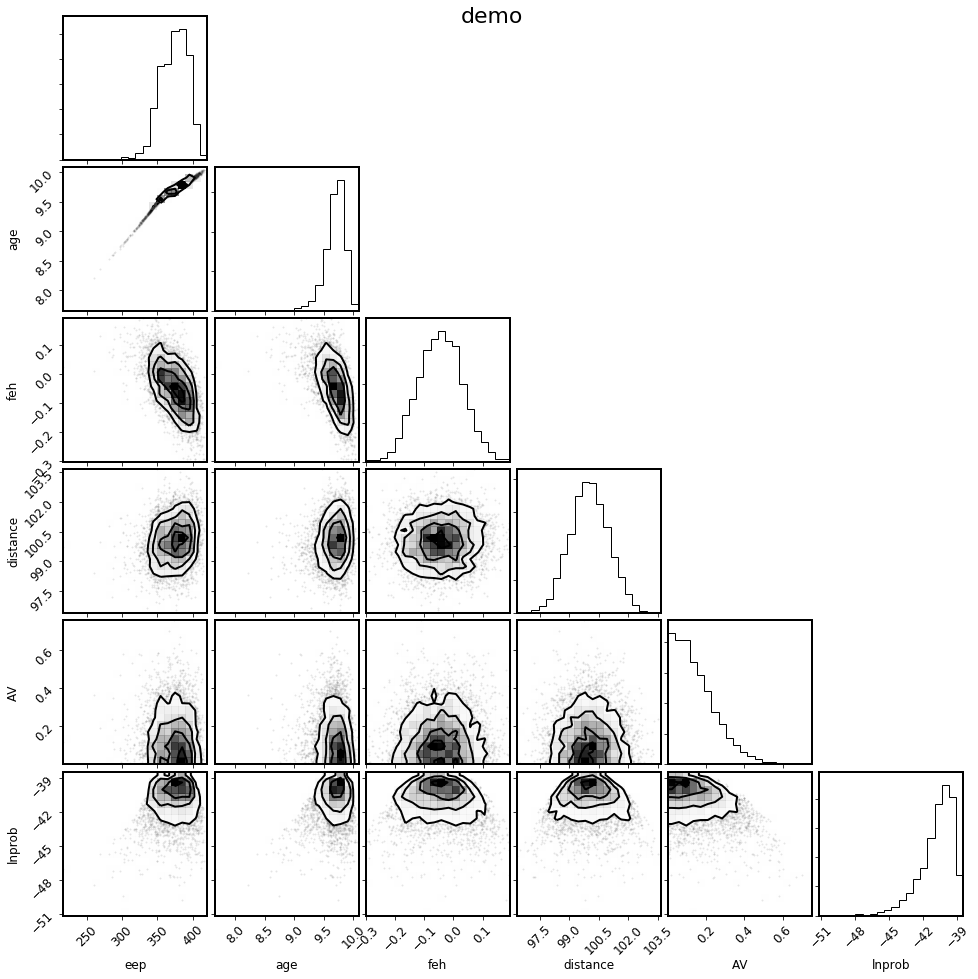

In [22]:
%matplotlib inline

mod.corner_params();  # Note, this is also new in v2.0, for the SingleStarModel object

There is also a convenience method to select the parameters of physical interest.

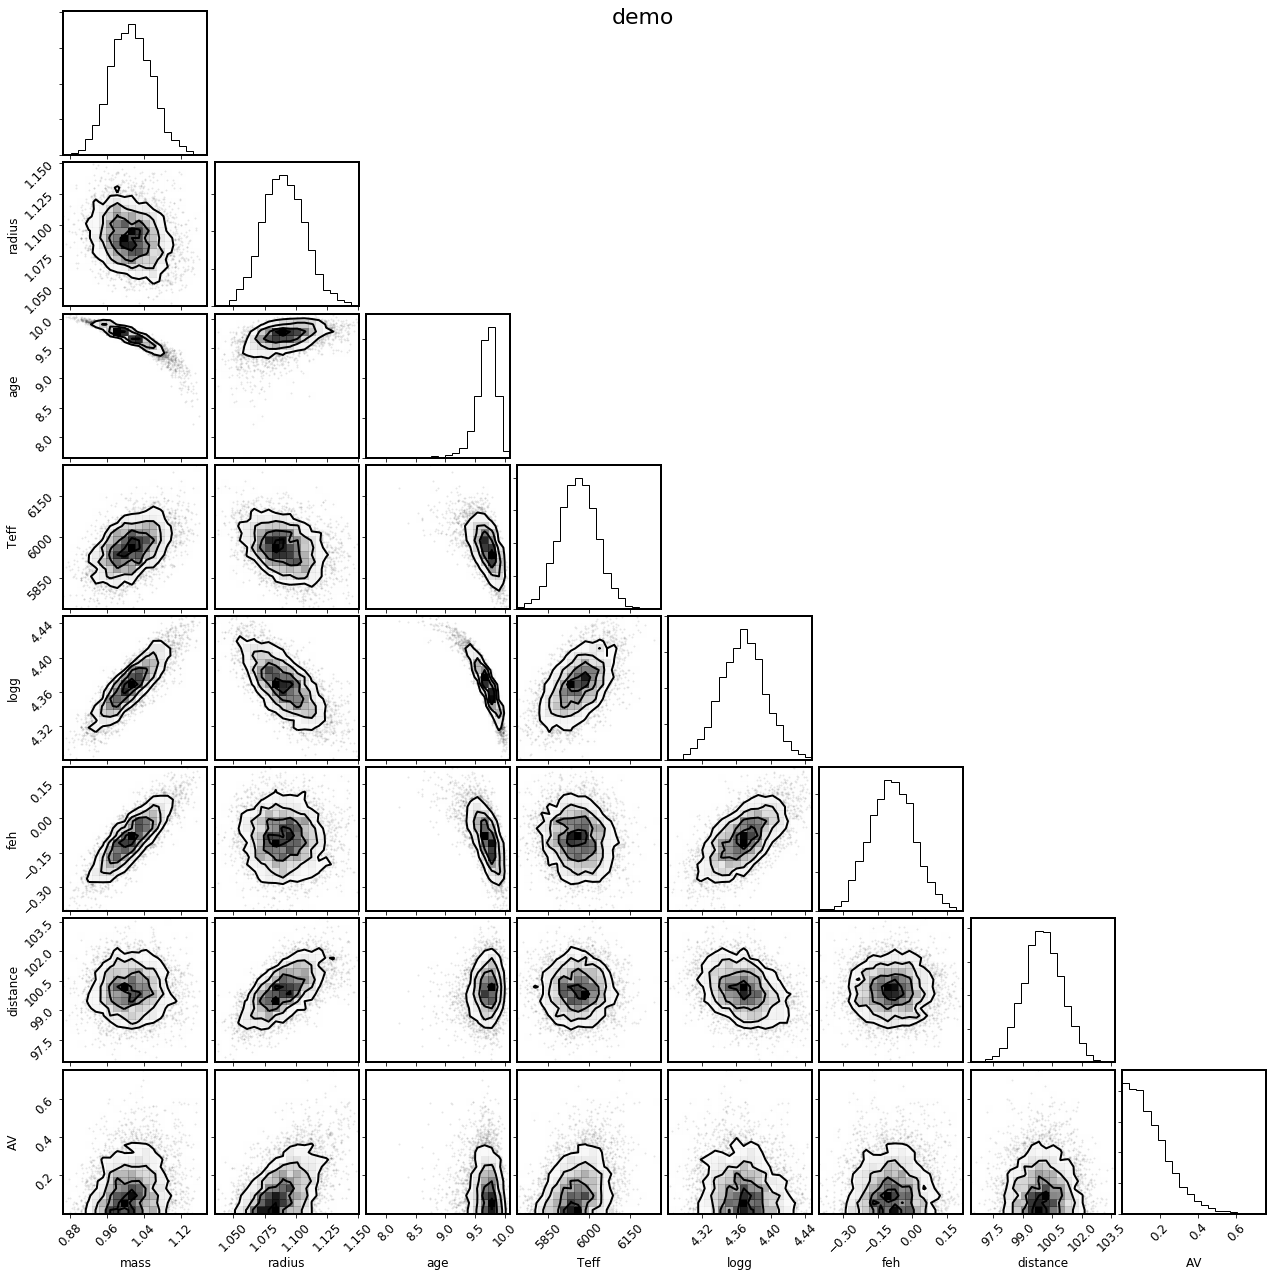

In [23]:
mod.corner_physical();

It can also be instructive to see how the derived samples of the observed parameters compare to the observations themselves; the shortcut to this is with the `.corner_observed()` convenience method:

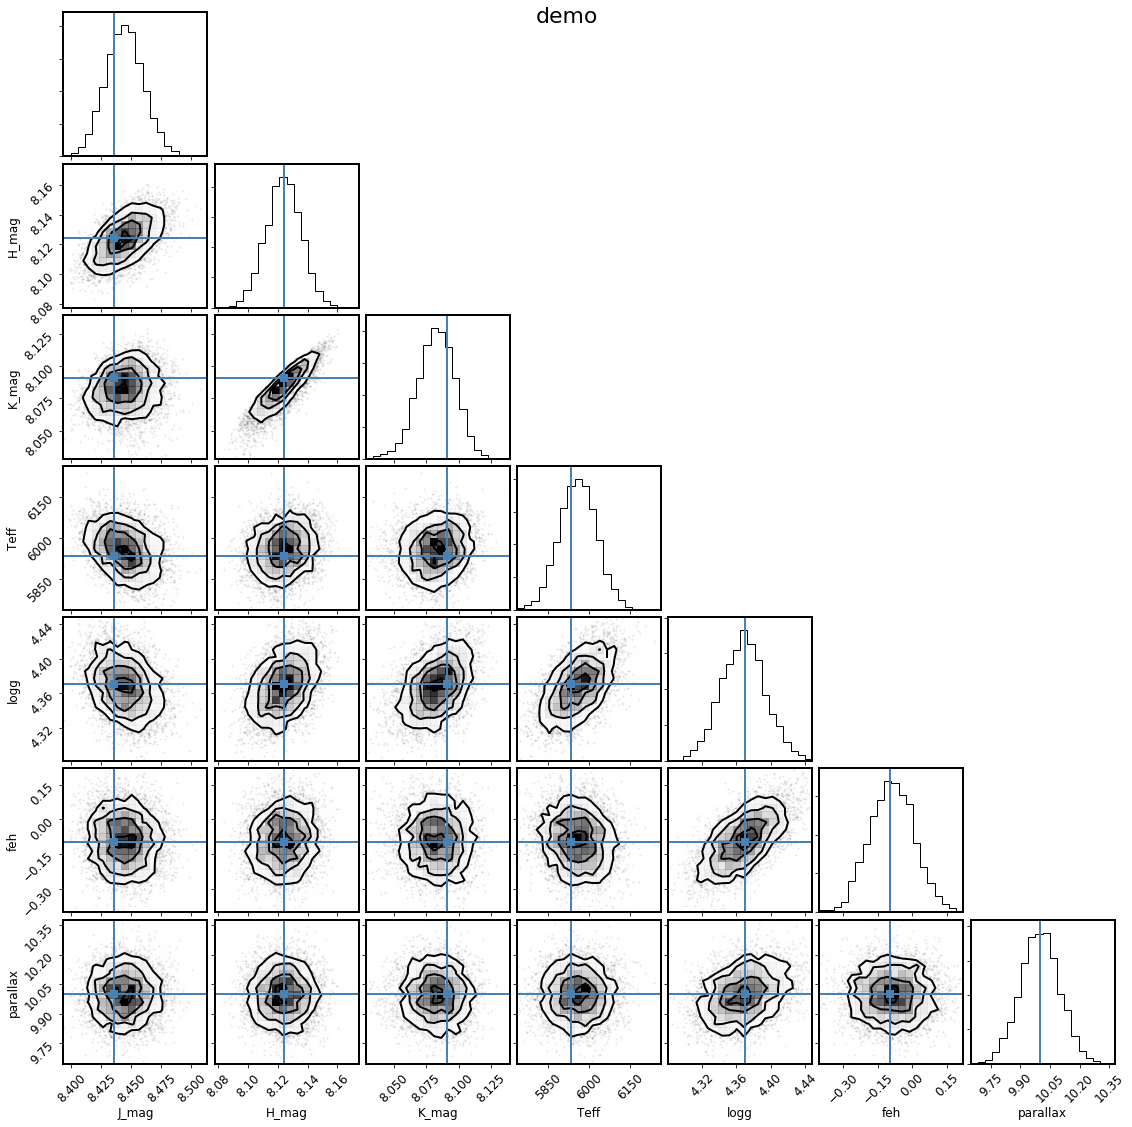

In [24]:
mod.corner_observed();

This looks good, because we generated the synthetic observations directly from the same stellar model grids that we used to fit.  For real data, this is an important figure to look at to see if any of the observations appear to be inconsistent with the others, and to see if the model is a good fit to the observations.

Generically, you can also make a corner plot of arbitrary derived parameters as follows:

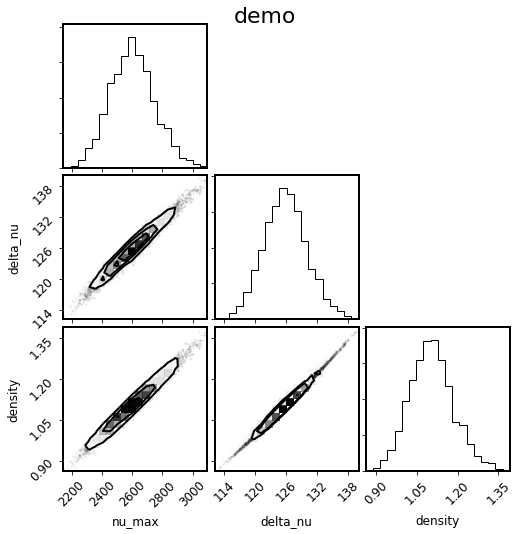

In [25]:
mod.corner_derived(['nu_max', 'delta_nu', 'density']);